title: Insurances & new devices    
author: Fabio Schmidt-Fischbach       
date: 2021-06-08       
region: EU   
link: https://docs.google.com/presentation/d/1t-F-4IHwiDaCGiC3SVmE2Hy6MvCKNqia6oqDT25h5Lo/edit?usp=sharing     
summary: After 12 months, 20% of users have paired a new phone. After 24 months, 32% of users have paired a new phone. We capture lots of pairings very early on e.g. within a month of the first pairing. This moves the median to the left at 5 months. Avg. time between pairings is 7 months.
tags: memberships, insurance, smartphone, device pairing    

In [20]:
import pandas as pd
import altair as alt
import numpy as np
from lifelines import KaplanMeierFitter

In [ ]:
query = """

with logins as ( 
	select distinct 
	    user_id, 
	    kyc_first_completed,
        country_tnc_legal, 
        product_id,
		device_manufacturer,
        device_model,
        case when platform = -1 then 'Web'
                         when platform=0 then 'Other'
                         when platform=1 then 'Android'
                         when platform=2 then 'iOS'
        end as platform,
        collector_tstamp::date login_date 
      from dbt.stg_logins 
      inner join dbt.zrh_users using (user_created)
      where 1=1 and collector_tstamp >= '2019-01-01' and kyc_first_completed >= '2019-01-01'
)

select 	distinct 
        ce_device_aud.user_id,
        date_trunc('week', kyc_first_completed::date) as age,
        country_tnc_legal, 
        product_id,
        device_manufacturer, 
        device_model, 
        rev_timestamp::date
from ce_device_aud 
inner join logins on logins.user_id = ce_device_aud.user_id 
						 and rev_timestamp::date = login_date 
where status ='PAIRED'
        and kyc_first_completed >= '2019-01-01'

"""

## how many unique paired devices do users have?

In [24]:
df = pd.read_csv("devices.csv")

df = df.loc[
    (df["device_model"].isna() == False) & (df["device_manufacturer"].isna() == False),
    :,
]
# df = df.loc[pd.to_datetime(df["age"])<pd.to_datetime('2020-01-01'),:]


df["model"] = df["device_manufacturer"] + df["device_model"]

df = df.groupby(["user_id"])["model"].agg("nunique").reset_index()
df = df.groupby(["model"])["user_id"].agg("nunique").reset_index()
df["perc"] = 100 * df["user_id"] / sum(df["user_id"])

alt.Chart(df.loc[df["model"] < 10, :]).mark_bar().encode(
    x=alt.X("model:Q", axis=alt.Axis(title="Number of unique models paired")),
    y=alt.Y("perc:Q", axis=alt.Axis(title="% of users")),
).properties(width=500, height=500, title="How many different devices did users pair?")

alt.Chart(...)

In [1]:
# df = pd.read_csv('devices.csv')

# df = df.loc[df["device_model"].isna()==False,:]

# df["model"] = df["device_manufacturer"] + df["device_model"]

# get "next model"
# df.sort_values(by=['user_id','rev_timestamp'], inplace=True)
# df["next_model"] = df.groupby("user_id")['model'].shift(-1)
# df = df.loc[(df["next_model"].isna()==True)|(df["model"]!=df["next_model"]),:]
# df.sort_values(by=['user_id','rev_timestamp'], inplace=True)
# df["next_pair"] = df.groupby("user_id")['rev_timestamp'].shift(-1)

# compute datediff
# df["differences"] = (pd.to_datetime(df["next_pair"]) - pd.to_datetime(df["rev_timestamp"])) / pd.Timedelta(weeks=1)
# df["churned"] = 0
# df.loc[df["next_model"].isna()==False,"churned"] = 1

# df.loc[df["churned"]==0, "differences"] = (pd.to_datetime("today")-pd.to_datetime(df["rev_timestamp"])) / pd.Timedelta(weeks=1)

# df.to_csv('devices_final.csv')

In [31]:
df = pd.read_csv("devices.csv")

df = df.loc[df["device_model"].isna() == False, :]

df["model"] = df["device_manufacturer"] + df["device_model"]

df = df.groupby(["user_id", "model"])["rev_timestamp"].agg("min").reset_index()

# get the next timestamp
df.sort_values(by=["user_id", "rev_timestamp"], inplace=True)
df["next_model"] = df.groupby("user_id")["model"].shift(-1)
df = df.loc[(df["next_model"].isna() == True) | (df["model"] != df["next_model"]), :]
df.sort_values(by=["user_id", "rev_timestamp"], inplace=True)
df["next_pair"] = df.groupby("user_id")["rev_timestamp"].shift(-1)

# compute datediff
df["differences"] = (
    pd.to_datetime(df["next_pair"]) - pd.to_datetime(df["rev_timestamp"])
) / pd.Timedelta(weeks=1)
df["churned"] = 0
df.loc[df["next_model"].isna() == False, "churned"] = 1

df.loc[df["churned"] == 0, "differences"] = (
    pd.to_datetime("today") - pd.to_datetime(df["rev_timestamp"])
) / pd.Timedelta(weeks=1)

df.to_csv("devices_final.csv")

In [13]:
df = pd.read_csv("devices_final.csv")

df = df.loc[
    (df["churned"] == 1)
    & (pd.to_datetime(df["next_pair"]) >= pd.to_datetime("2020-01-01")),
    :,
]

df["year"] = pd.to_datetime(df["next_pair"]).dt.year
df["month"] = pd.to_datetime(df["next_pair"]).dt.month

df["next_pair"] = df["year"].astype(str) + "-" + df["month"].astype(str)

df = df.groupby(["next_pair"])["user_id"].agg("nunique").reset_index()

alt.Chart(df.loc[df["next_pair"] != "2021-6", :]).mark_line().encode(
    x=alt.X("next_pair:T", axis=alt.Axis(title="Pairing date")),
    y=alt.Y("user_id:Q", axis=alt.Axis(title="# of users")),
).properties(title="# of newly paired devices", width=500, height=500)

alt.Chart(...)

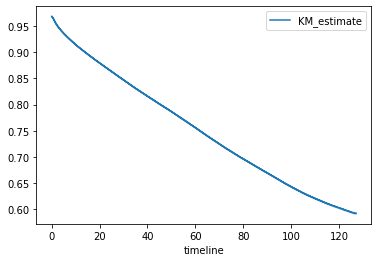

In [25]:
df = pd.read_csv("devices_final.csv")

# only keep the first row of each user.
df.sort_values(by=["user_id", "rev_timestamp"], inplace=True)
df["rn"] = df.groupby("user_id").cumcount()

df = df.loc[df["rn"] == 0, :]

# estimate survival model
kmf = KaplanMeierFitter()
kmf.fit(df["differences"], event_observed=df["churned"])

kmf.plot()

In [35]:
df = pd.DataFrame(kmf.survival_function_).reset_index()

df["timeline_months"] = round(df["timeline"] / 4)


alt.Chart(df).mark_line().encode(
    x=alt.X(
        "timeline_months:Q", axis=alt.Axis(title="# of months since first pairing")
    ),
    y=alt.Y(
        "KM_estimate:Q",
        axis=alt.Axis(
            title="% of users who have paired at least one new phone", format="%"
        ),
    ),
).properties(width=500, height=500, title="Survival function - phone pairings")

alt.Chart(...)

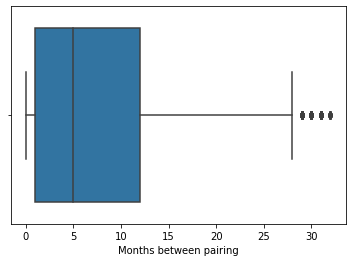

In [37]:
import seaborn as sns

d = pd.read_csv("devices_final.csv")

d = d.loc[(d["churned"] == 1), :]
d["Months between pairing"] = round(d["differences"] / 4)

sns.boxplot(x=d["Months between pairing"])

In [39]:
import seaborn as sns

d = pd.read_csv("devices_final.csv")

d = d.loc[(d["churned"] == 1), :]
d["Months between pairing"] = round(d["differences"] / 4)

np.mean(d["Months between pairing"])

7.294731443535312

In [38]:
d = pd.read_csv("devices_final.csv")

d = d.loc[(d["churned"] == 1), :]

d["differences"] = round(d["differences"] / 4)

d = d.groupby(["differences"])["user_id"].count().reset_index()

d["perc"] = 100 * d["user_id"] / sum(d["user_id"])

alt.Chart(d).mark_line().encode(
    x=alt.X("differences:Q", axis=alt.Axis(title="Months between pairing")),
    y=alt.Y("perc:Q", axis=alt.Axis(title="% of users")),
)

alt.Chart(...)